In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns 
#np.set_printoptions(precision=2,linewidth=800,suppress=True)

In [2]:
#food_data = pd.read_csv('/content/drive/MyDrive/food_openfood.csv', sep='\t')
data_model = pd.read_csv('https://raw.githubusercontent.com/bachir151/stage/master/data_model.csv', sep=',')

In [3]:
data_model =data_model.drop(['Unnamed: 0'], axis=1)

Séparation du jeu de données 

In [4]:
numerical_features = data_model.select_dtypes(include=['int64','float64']).columns.to_list()
categorical_features = data_model.select_dtypes(exclude=['int64','float64']).columns.to_list()

In [5]:
X= data_model[['NumberofBuildings','NumberofFloors','PropertyGFATotal','ENERGYSTARScore','age_batiment','PrimaryPropertyType']]
Y = data_model[['SiteEnergyUse(kBtu)','TotalGHGEmissions']]

### Passage au log pour notre varaible target TotalGHGEmissions

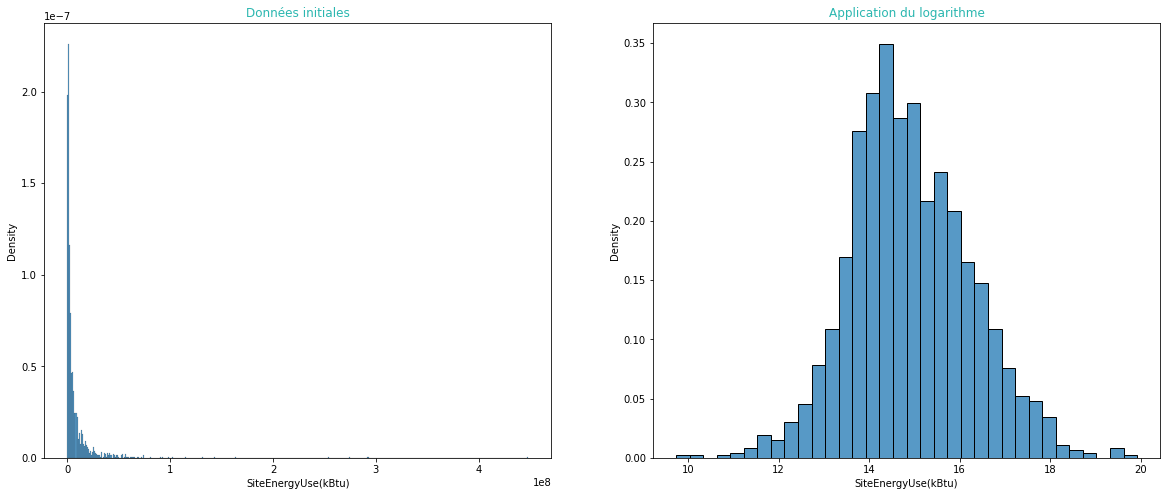

In [6]:
from sklearn.preprocessing import FunctionTransformer

logtransformer = FunctionTransformer(np.log, inverse_func = np.exp, check_inverse = True)
Y_log = logtransformer.transform(Y)

fig, axes = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=(20,8))
sns.histplot(data=Y, x='SiteEnergyUse(kBtu)', stat="density", ax=axes[0])
axes[0].set_title("Données initiales", color='#2cb7b0')
sns.histplot(data=Y_log, x='SiteEnergyUse(kBtu)', stat="density", ax=axes[1])
axes[1].set_title("Application du logarithme", color='#2cb7b0')
#plt.suptitle("Distribution des emissions de CO2 avec changement d'échelle", fontdict=font_title, fontsize=22)
plt.show()

###Pipeline utilisé

In [7]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import *
from sklearn.svm import LinearSVR
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import *
from sklearn.model_selection import GridSearchCV

from sklearn import set_config
set_config(display='diagram')

#plot distribution de la target et voir le scaler à utiliser 

Modèle baseline : Régression linéaire

In [8]:
# Création de piepeline pour les features numériques et catégoriels   ----  'SiteEnergyUse(kBtu)','TotalGHGEmissions',
numerical_features  =  ['NumberofBuildings','NumberofFloors','PropertyGFATotal','ENERGYSTARScore','age_batiment']
categorical_features  = ['PrimaryPropertyType']


numerical_pipeline = Pipeline(steps=[
      ('impute', SimpleImputer(strategy='mean')),
      ('scale',StandardScaler())
  ])
categorical_pipeline= Pipeline(steps=[
      ('impute', SimpleImputer(strategy='most_frequent')),
      ('one-hot',OneHotEncoder())
  ])


  # Création d'un ColumnTransformer pour appliquer un pipeline pour chaque type de colonne

preprocessor = ColumnTransformer(transformers=[
      ('numerical_pipeline',numerical_pipeline,numerical_features),
      ('categorical_pipeline=',categorical_pipeline,categorical_features )
      ],
      remainder='passthrough',
      #n_jobs=-1,
      )


# Ajouter le modèle au pipeline final
model_baseline= Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", LinearRegression(fit_intercept=False) )]
)


#X = data_model.drop(['SiteEnergyUse(kBtu)','TotalGHGEmissions'], axis=1)
#Y = data_model[['SiteEnergyUse(kBtu)','TotalGHGEmissions']]



X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.4, random_state=8)


model_baseline.fit (X_train,Y_train['SiteEnergyUse(kBtu)'])


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numerical_pipeline',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer()),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['NumberofBuildings',
                                                   'NumberofFloors',
                                                   'PropertyGFATotal',
                                                   'ENERGYSTARScore',
                                                   'age_batiment']),
                                                 ('categorical_pipeline=',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('one-hot',
                                                                   OneHotEncoder())]),
                                                  ['PrimaryPropertyType'])])),
                ('classifier', LinearRegression(fit_intercept=False))])

On utilise deux métriques pour l’évaluation L’erreur absolue moyenne et le R-square (la qualité du modèle de régression)

In [9]:
y_train_predict = model_baseline.predict(X_train)
rmse = (mean_absolute_error(Y_train['SiteEnergyUse(kBtu)'], y_train_predict))
r2 = r2_score(Y_train['SiteEnergyUse(kBtu)'], y_train_predict)
 
print('La performance du modèle sur la base dapprentissage')
print('--------------------------------------------------')
print('MAE : {}'.format(rmse))
#print(f'MSE : {mean_squared_error(Y_train['TotalGHGEmissions'], y_train_predict)}')
print('le score R2 est : {}'.format(r2))
print('\n')
 
# model evaluation for testing set
y_test_predict = model_baseline.predict(X_test)
rmse = (mean_absolute_error(Y_test['SiteEnergyUse(kBtu)'], y_test_predict))
r2 = r2_score(Y_test['SiteEnergyUse(kBtu)'], y_test_predict)
 
print('La performance du modèle sur la base de test')
print('------------------------------------------------------')
print('MAE: {}'.format(rmse))
print('le score R2 est : {}'.format(r2))

La performance du modèle sur la base dapprentissage
--------------------------------------------------
MAE : 6420702.2934692325
le score R2 est : 0.3875895417802472


La performance du modèle sur la base de test
------------------------------------------------------
MAE: 5204178.1821894515
le score R2 est : 0.49370352713019217


Valeurs prédites vs valeurs réelles de notre modèle baseline

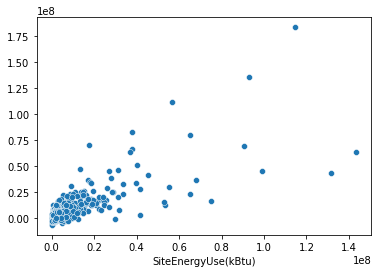

In [10]:
# traçage de y_test versus y_pred
# l'idéal aurait dû être une ligne droite
#y_test_predict = model_baseline.predict(X_test)
sns.scatterplot(x=Y_test['SiteEnergyUse(kBtu)'], y=y_test_predict)

Pipeline, paramètre  et Gridsearch de tous les modèles à tester 

In [11]:
#Régression linéaire multiple
from sklearn.compose import TransformedTargetRegressor
nb_split = 5

pipe_lr = Pipeline(
    steps=[("preprocessor", preprocessor), ("LR", TransformedTargetRegressor(regressor=LinearRegression(), func=np.log, inverse_func=np.exp) )]
)

myscore = ('r2','neg_mean_absolute_error')

lr_param_grid = [ {"LR__regressor__fit_intercept": [True, False]}   ] 

score = ['accuracy','neg_mean_absolute_error']
lr_grid_search = GridSearchCV(estimator=pipe_lr,
        param_grid=lr_param_grid, refit='neg_mean_absolute_error',
        scoring=myscore,
        cv=nb_split,return_train_score=True)


tt = TransformedTargetRegressor(regressor=lr_grid_search ,
                                 func=np.log, inverse_func=np.exp)

#Elastic Net

pipe_elastic = Pipeline(
    steps=[("preprocessor", preprocessor), ("ELN", TransformedTargetRegressor(regressor=ElasticNet() ,func=np.log, inverse_func=np.exp) )]
)

elastic_param_grid = [     {"ELN__regressor__max_iter": [10, 100, 1000],
                            "ELN__regressor__alpha": np.logspace(-4, 0, num=5),
                             "ELN__regressor__l1_ratio": np.arange(0.0, 1.1, 0.1) } ]   

elastic_grid_search = GridSearchCV(estimator=pipe_elastic,
        param_grid=elastic_param_grid,
        scoring=myscore, refit='neg_mean_absolute_error',
        cv=nb_split,return_train_score=True) 

# Linear SVM
pipe_lsvr =Pipeline(
    steps=[("preprocessor", preprocessor), ("LSVR", TransformedTargetRegressor(regressor=LinearSVR() ,func=np.log, inverse_func=np.exp) )]
)

lsvr_param_grid = [      {'LSVR__regressor__C' : np.logspace(-4, 0, 5),
                          'LSVR__regressor__epsilon' : [0, 0.01, 0.1, 0.5, 1, 2],
                         'LSVR__regressor__loss' : ["epsilon_insensitive","squared_epsilon_insensitive"],
                          'LSVR__regressor__max_iter': [10, 100, 1000]}   ]    
lsvr_grid_search = GridSearchCV(estimator=pipe_lsvr,
        param_grid=lsvr_param_grid,
        scoring=myscore, refit='neg_mean_absolute_error',
        cv=nb_split, return_train_score=True)

# Random Forest
pipe_rfr= Pipeline(
    steps=[("preprocessor", preprocessor), ("RFR", TransformedTargetRegressor(regressor=RandomForestRegressor() ,func=np.log, inverse_func=np.exp) )]
)

rfr_param_grid = [ {'RFR__regressor__max_features' : ['sqrt', 'log2'],
                   'RFR__regressor__max_depth': [5, 15, 25, 50],
                   'RFR__regressor__min_samples_split': [2, 5, 10],
                   'RFR__regressor__bootstrap' : [True, False],
                   'RFR__regressor__min_samples_leaf': [1,2,5,10]}
                                                    ]  
rfr_grid_search = GridSearchCV(estimator=pipe_rfr,
        param_grid=rfr_param_grid,
        scoring=myscore, refit='neg_mean_absolute_error',
        cv=nb_split, return_train_score=True)                                                  
                                                 
# Rajouter une métrique pour GridSearch
# Xgboost Regressor
pipe_xgbr = Pipeline(
    steps=[("preprocessor", preprocessor), ("xgbr", xgb.XGBRegressor(tree_method='gpu_hist'))]
)


"""xgbr_param_grid = [ {'xgbr__learning_rate' : [0.001, 0.01, 0.1, 0.2, 0,3],
                          'xgbr__gamma': [0, 0.25, 0.5, 1.0],
                           'xgbr__max_depth': [6, 10, 15, 20],
                          'xgbr__min_child_weight' : [0.5, 1.0, 3.0, 5.0, 7.0, 10.0],
                          'xgbr__n_estimators': [25, 50, 100, 500, 1000]}  ]   """


grid_result = lr_grid_search.fit(X_train,Y_train['SiteEnergyUse(kBtu)'])
pd.DataFrame(grid_result.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_LR__regressor__fit_intercept,params,split0_test_r2,split1_test_r2,split2_test_r2,split3_test_r2,...,mean_test_neg_mean_absolute_error,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error,split0_train_neg_mean_absolute_error,split1_train_neg_mean_absolute_error,split2_train_neg_mean_absolute_error,split3_train_neg_mean_absolute_error,split4_train_neg_mean_absolute_error,mean_train_neg_mean_absolute_error,std_train_neg_mean_absolute_error
0,0.034700,0.011827,0.029857,0.021797,True,{'LR__regressor__fit_intercept': True},-0.439302,-26.909734,0.455437,-2.222015,...,-1.070483e+07,6.088990e+06,2,-8.055695e+06,-7.790133e+06,-8.232445e+06,-9.412485e+06,-1.050156e+07,-8.798465e+06,1.016502e+06
1,0.027527,0.004167,0.011397,0.001120,False,{'LR__regressor__fit_intercept': False},-0.439302,-26.909734,0.455437,-2.222015,...,-1.070483e+07,6.088990e+06,1,-8.055695e+06,-7.790133e+06,-8.232445e+06,-9.412485e+06,-1.050156e+07,-8.798465e+06,1.016502e+06


Entrainement des modèles et choix des meilleurs modèles

In [12]:
import warnings
warnings.filterwarnings('ignore')

global target
global lr_grid_search_model , elastic_grid_search_model, lsvr_grid_search_model, rfr_grid_search_model 

target = ['TotalGHGEmissions', 'SiteEnergyUse(kBtu)']

In [13]:
target_x =target[1]
lr_grid_search_model = lr_grid_search.fit(X_train,Y_train[target_x])
elastic_grid_search_model = elastic_grid_search.fit(X_train,Y_train[target_x])
lsvr_grid_search_model = lsvr_grid_search.fit(X_train,Y_train[target_x])
rfr_grid_search_model = rfr_grid_search.fit(X_train,Y_train[target_x])

## <ins> Choix du modèle pour la variable target 'SiteEnergyUse(kBtu)' </ins>

In [14]:
a=pd.DataFrame(lr_grid_search_model.cv_results_)[['params',	'mean_fit_time', 'mean_test_neg_mean_absolute_error','mean_test_r2'	,'std_train_neg_mean_absolute_error', 'rank_test_neg_mean_absolute_error']].sort_values(by='rank_test_neg_mean_absolute_error').head(1)
b=pd.DataFrame(elastic_grid_search_model.cv_results_)[['params',	'mean_fit_time', 'mean_test_neg_mean_absolute_error','mean_test_r2'	,'std_train_neg_mean_absolute_error', 'rank_test_neg_mean_absolute_error']].sort_values(by='rank_test_neg_mean_absolute_error').head(1)
c=pd.DataFrame(lsvr_grid_search_model.cv_results_)[['params',	'mean_fit_time', 'mean_test_neg_mean_absolute_error','mean_test_r2'	,'std_train_neg_mean_absolute_error', 'rank_test_neg_mean_absolute_error']].sort_values(by='rank_test_neg_mean_absolute_error').head(1)
d=pd.DataFrame(rfr_grid_search_model.cv_results_)[['params',	'mean_fit_time', 'mean_test_neg_mean_absolute_error','mean_test_r2'	,'std_train_neg_mean_absolute_error', 'rank_test_neg_mean_absolute_error']].sort_values(by='rank_test_neg_mean_absolute_error').head(1)
R=pd.concat([a, b,c,d])
R["Modèles"] = ['LinearRegression', 'ElasticNet', 'SVR', 'RandomForest']
R

,params,mean_fit_time,mean_test_neg_mean_absolute_error,mean_test_r2,std_train_neg_mean_absolute_error,rank_test_neg_mean_absolute_error,Modèles
1,{'LR__regressor__fit_intercept': False},0.045867,-1.070483e+07,-11.625577,1.016502e+06,1,LinearRegression
133,"{'ELN__regressor__alpha': 1.0, 'ELN__regressor...",0.027217,-6.365609e+06,0.149162,2.990004e+05,1,ElasticNet
144,"{'LSVR__regressor__C': 1.0, 'LSVR__regressor__...",0.016477,-6.932399e+06,-0.532467,5.953957e+06,1,SVR
169,"{'RFR__regressor__bootstrap': False, 'RFR__reg...",0.167383,-4.457843e+06,0.494213,1.531824e+05,1,RandomForest


Avec la graphique ci-dessus, on constate que le modèle RandomForestRegressor offre le meilleur score **MAE** (=-133) et un meilleur $R^2$ (=0.4) . On rentiendra ce modèle pour la modélisation de la 
variable **TotalGHGEmissions** est donc le modèle RandomForestRegressor.

Temps d'entrainement des modèles

In [15]:
import plotly.graph_objects as go
fig = go.Figure([ go.Bar(name='temps entrainement',x=R['Modèles'], y=R['mean_fit_time'])])
fig.update_layout(barmode='group')

fig.show()

Observons les scores obtenus sur les différents splits de la Cross-validation :

### Code

In [16]:
import plotly.express as px
def trace_mae() :
  t1=pd.DataFrame(rfr_grid_search_model.cv_results_)[["split0_train_neg_mean_absolute_error",	"split1_train_neg_mean_absolute_error","split2_train_neg_mean_absolute_error",	"split3_train_neg_mean_absolute_error",	"split4_train_neg_mean_absolute_error"	,"rank_test_neg_mean_absolute_error"]].sort_values(by='rank_test_neg_mean_absolute_error').head(1)
  t1=pd.DataFrame(rfr_grid_search_model.cv_results_)[["split0_train_neg_mean_absolute_error",	"split1_train_neg_mean_absolute_error","split2_train_neg_mean_absolute_error",	"split3_train_neg_mean_absolute_error","split4_train_neg_mean_absolute_error"]]
  t2= pd.DataFrame(rfr_grid_search_model.cv_results_)[["split0_test_neg_mean_absolute_error",	"split1_test_neg_mean_absolute_error","split2_test_neg_mean_absolute_error",	"split3_test_neg_mean_absolute_error",	"split4_test_neg_mean_absolute_error"	,"rank_test_neg_mean_absolute_error"]].sort_values(by='rank_test_neg_mean_absolute_error').head(1)
  t2= pd.DataFrame(rfr_grid_search_model.cv_results_)[["split0_test_neg_mean_absolute_error",	"split1_test_neg_mean_absolute_error","split2_test_neg_mean_absolute_error",	"split3_test_neg_mean_absolute_error",	"split4_test_neg_mean_absolute_error"]]

  df1_transposed = t1.T
  df1_transposed 
  df2_transposed = t2.T
  final=pd.concat ([df1_transposed,df2_transposed ])
  final["Split_cross validation"] = list(range(nb_split)) + list(range(nb_split))
  final.rename(columns={0: "MAE"}, inplace=True)
  final=final.reset_index()
  final ["color"] = np.where( final["index"].str.contains("test"), "test", "train")
  final

  fig = px.line( final, x='Split_cross validation',y='MAE', color='color', symbol="color")
  fig.show()

def trace_r2() :
    t1=pd.DataFrame(rfr_grid_search_model.cv_results_)[["split0_train_r2",	"split1_train_r2","split2_train_r2",	"split3_train_r2",	"split4_train_r2"	,"rank_test_neg_mean_absolute_error"]].sort_values(by='rank_test_neg_mean_absolute_error').head(1)
    t1=pd.DataFrame(rfr_grid_search_model.cv_results_)[["split0_train_r2",	"split1_train_r2","split2_train_r2",	"split3_train_r2","split4_train_r2"]]
    t2= pd.DataFrame(rfr_grid_search_model.cv_results_)[["split0_test_r2",	"split1_test_r2","split2_test_r2",	"split3_test_r2",	"split4_test_r2"	,"rank_test_neg_mean_absolute_error"]].sort_values(by='rank_test_neg_mean_absolute_error').head(1)
    t2= pd.DataFrame(rfr_grid_search_model.cv_results_)[["split0_test_r2",	"split1_test_r2","split2_test_r2",	"split3_test_r2",	"split4_test_r2"]]

    df1_transposed = t1.T
    df1_transposed 
    df2_transposed = t2.T
    final=pd.concat ([df1_transposed,df2_transposed ])
    final["Split_cross validation"] = list(range(nb_split)) + list(range(nb_split))
    final.rename(columns={0: "R2"}, inplace=True)
    final=final.reset_index()
    final ["color"] = np.where( final["index"].str.contains("test"), "test", "train")
    final

    fig = px.line( final, x='Split_cross validation',y='R2', color='color', symbol="color")
    fig.show()



### Performance de notre modèle selectionné dans le train et le test set de  chaque split de la crossvalidation.

In [17]:
trace_mae()
trace_r2()

On voit bien ici que la performance du modèle sur les données se rapproche de celle sur les données de test. On peut ne pas envisager un overffiting de notre modèle séléctionné.

### Score de notre modèle  sur le test set 

In [18]:
from sklearn.metrics import median_absolute_error, r2_score
y_test_predict = rfr_grid_search_model.predict(X_test)
def compute_score(y_true, y_pred):
    return {
        "R2": f"{r2_score(y_true, y_pred):.3f}",
        "MedAE": f"{median_absolute_error(y_true, y_pred):.3f}",
    }
print(compute_score(Y_test[target[1]], y_test_predict ) ) 

{'R2': '0.401', 'MedAE': '935118.423'}


Sur le test set Le MAE du modèle s'est amélioré tandis que son $R^2$ est presque divisé par 2.

Valeurs prédites vs valeurs réelles

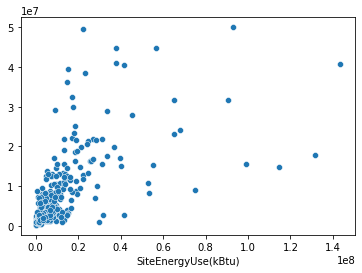

In [19]:
# traçage de y_test versus y_pred
# l'idéal aurait dû être une ligne droite
sns.scatterplot(x=Y_test[target[1]], y=y_test_predict)

Ici, le modèle est n'est pas très bien ajusté aux données. 